In [43]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
from torch import nn
import os
import shutil
from koopman.simulation.simulator import simulate, simulate_batch
from koopman.simulation.systems import DynamicalSystem, VanDerPolOscillator
from koopman.edmd.edmd import eDMD
from sklearn.preprocessing import PolynomialFeatures
from numpy.polynomial.chebyshev import Chebyshev
from spatialmath.base import angle_wrap
from scipy.ndimage import gaussian_filter1d

from koopman import utils
from koopman.autoencoder.dataset import KoopmanDataset
from koopman.autoencoder.model import KoopmanAutoencoder
from koopman.autoencoder.training_loop import simulate_with_observables, train
from koopman.autoencoder.dataset import KoopmanDatasetStats

SCRIPT_DIR = '/home/mreich/workspaces/koopman/koopman/edmd/van_der_pol'

def get_random_visible_color():
    # Sample hue randomly, fix saturation and value for vibrancy
    h = np.random.rand()           # Hue ∈ [0, 1]
    s = np.random.uniform(0.6, 1)  # Saturation: avoid pale colors
    v = np.random.uniform(0.7, 1)  # Value (brightness): avoid dark
    return mcolors.hsv_to_rgb((h, s, v))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Run a simulation with the Van Der Pol system
vanderpol = VanDerPolOscillator()

N = 1_000
x0 = np.random.uniform(-1, 1, (N, 2))
tf = 10.0
dt = 0.05
T = int(tf/dt)
# controls = np.random.randn(N, T, 1) * 5.0
controls = np.zeros((N, T, 1)) #np.random.randn(N, T, 1) * 5.0

ts, xhist, uhist = simulate_batch(
    sys=vanderpol,
    tf=tf,
    dt=dt,
    u=controls,
    x0=x0
)

print(f"Simulation finished. {xhist.shape=}, {uhist.shape=}")

Simulation progress:   0%|          | 0/200 [00:00<?, ?it/s]

Simulation progress: 100%|██████████| 200/200 [00:00<00:00, 813.96it/s]

Simulation finished. xhist.shape=(500, 201, 2), uhist.shape=(500, 200, 1)


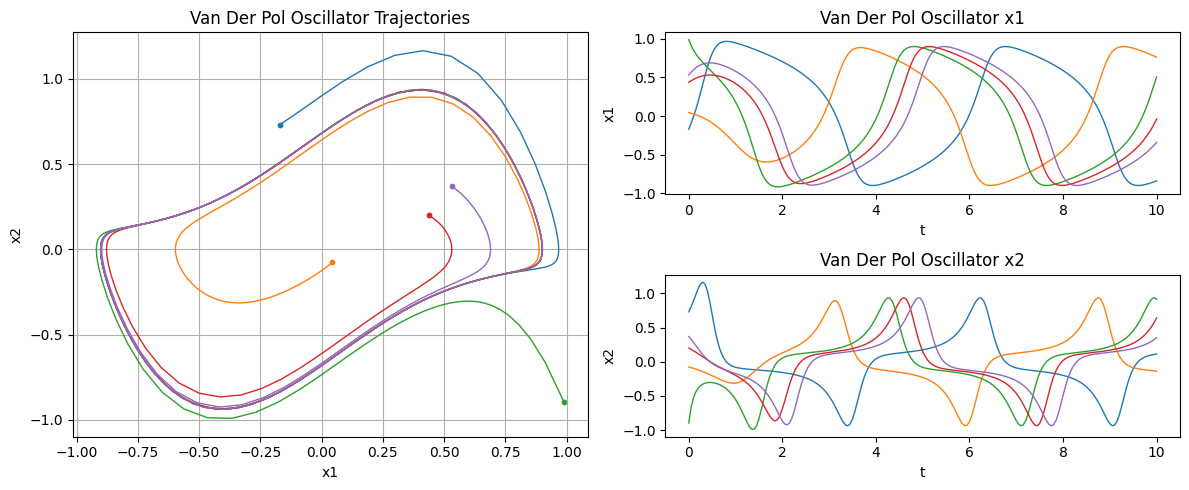

In [45]:
trajectory_samples = xhist[np.random.randint(0, N, 5), :, :]

# Plot the trajectory
def plot_trajectory(ax_traj, ax_x1, ax_x2, xhist, ts, label=None):
    x = ax_traj.plot(xhist[:, 0], xhist[:, 1], linewidth=1)
    color = x[0].get_color()
    _ = ax_traj.scatter(xhist[0, 0], xhist[0, 1], color=color, s=10, label=label)
    _ = ax_x1.plot(ts, xhist[:, 0], color=color, linewidth=1)
    _ = ax_x2.plot(ts, xhist[:, 1], color=color, linewidth=1)


fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1])

ax_traj = fig.add_subplot(fig.add_subplot(gs[:, 0]))
ax_x1 = fig.add_subplot(gs[0, 1])
ax_x2 = fig.add_subplot(gs[1, 1])

for i in range(trajectory_samples.shape[0]):
    plot_trajectory(ax_traj, ax_x1, ax_x2, trajectory_samples[i], ts, label=None)
    
ax_traj.set_title("Van Der Pol Oscillator Trajectories")
ax_traj.set_xlabel("x1")
ax_traj.set_ylabel("x2")
ax_traj.grid()

ax_x1.set_title("Van Der Pol Oscillator x1")
ax_x1.set_xlabel("t")
ax_x1.set_ylabel("x1")

ax_x2.set_title("Van Der Pol Oscillator x2")
ax_x2.set_xlabel("t")
ax_x2.set_ylabel("x2")

plt.tight_layout()
plt.show()

In [ ]:
def evaluate(model: KoopmanAutoencoder, dataset: KoopmanDataset, epoch_idx, device: torch.device):
    xhist, uhist, ts = dataset.sample_eval_trajectories(1)
    x0 = xhist[0, :]
    xhist_pred, _ = simulate_with_observables(model, x0, uhist, device)

    # Create a plot of the state evolution prediction over time vs. true state
    xhist = utils.torch_to_numpy(xhist)
    uhist = utils.torch_to_numpy(uhist)
    xhist_pred = utils.torch_to_numpy(xhist_pred)
    ts = utils.torch_to_numpy(ts)
    
    # Plotting
    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 1])

    ax_traj = fig.add_subplot(fig.add_subplot(gs[:, 0]))
    ax_x1 = fig.add_subplot(gs[0, 1])
    ax_x2 = fig.add_subplot(gs[1, 1])

    plot_trajectory(ax_traj, ax_x1, ax_x2, xhist, ts, label="True")
    plot_trajectory(ax_traj, ax_x1, ax_x2, xhist_pred, ts, label="Pred")
        
    ax_traj.set_title("Van Der Pol Oscillator Trajectories")
    ax_traj.set_xlabel("x1")
    ax_traj.set_ylabel("x2")
    ax_traj.grid()
    ax_traj.legend()
    ax_traj.set_aspect('equal', adjustable='box')

    ax_x1.set_title("Van Der Pol Oscillator x1")
    ax_x1.set_xlabel("t")
    ax_x1.set_ylabel("x1")

    ax_x2.set_title("Van Der Pol Oscillator x2")
    ax_x2.set_xlabel("t")
    ax_x2.set_ylabel("x2")

    fig.suptitle(f"Epoch {epoch_idx} - State Prediction vs. True State")
    
    plt.tight_layout()
    plt.savefig(os.path.join(SCRIPT_DIR, "eval_plots", f"vanderpol_epoch_{epoch_idx}.png"))
    plt.close(fig)

    return xhist, uhist, xhist_pred

In [58]:
eval_plots_dir = os.path.join(SCRIPT_DIR, "eval_plots")
if os.path.exists(eval_plots_dir):
    shutil.rmtree(eval_plots_dir)
os.makedirs(eval_plots_dir, exist_ok=True)

model = KoopmanAutoencoder(
    nx=VanDerPolOscillator.nx,
    nu=VanDerPolOscillator.nu,
    nz=100 + 2,
    dt=dt,
    horizon_loss_weight_x=2.0,
    horizon_loss_weight_z=2.0,
    L1_reg_weight=0.0,
    hidden_dims=[128, 128, 128],
    activation=nn.Tanh,
)

xhist_tensor = torch.as_tensor(xhist, dtype=torch.float32)
uhist_tensor = torch.as_tensor(uhist, dtype=torch.float32)
ts_tensor = torch.as_tensor(ts, dtype=torch.float32)

stats = KoopmanDatasetStats.from_tensors(xhist_tensor, uhist_tensor, dt)
dataset = KoopmanDataset(xhist_tensor, uhist_tensor, ts_tensor, stats, pred_horizon=50, normalize=False)

train(model, dataset,
      n_epochs=100,
      batch_size=512,
      learning_rate=1e-3,
      evaluate=evaluate,
      save_dir=SCRIPT_DIR)

Beginning training...
    Dataset info:
	xhist shape: torch.Size([500, 201, 2])
	uhist shape: torch.Size([500, 200, 1])
	dt: 0.05000000074505806
    Training info:
	Batch size: 512
	Learning rate: 0.001
	Epochs: 100
	Device: cuda
	Num params: 67422


Epoch 99: 100%|██████████| 118/118 [00:07<00:00, 16.63batch/s, loss=0.000184, lr=0.001000]
